## Image Denoising Experiments
- Step 1: Set-up
- Step 2: Load data & Build UNet model
- Step 3: Image denoising using UNet with different optimizers using default parameters
- Step 4: Hyperparameter tuning
- Step 5: Tuned performance and analysis of importance of tunining for optmizers
- Step 6: Plot results

################################# ATTENTION ############################################

If the user does not want to run the full training/testing, he/she can run Step 1 and then move to Step 6 to plot the results.

################################# ATTENTION ############################################

#### Step 1: Set-up

In [1]:
! pip install madgrad
! pip install adabelief-pytorch==0.2.0
! pip install optuna

You should consider upgrading via the 'c:\users\lucaz\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lucaz\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\lucaz\anaconda3\python.exe -m pip install --upgrade pip' command.


Import libraries


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from adabelief_pytorch import AdaBelief
from madgrad import MADGRAD
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import pickle

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.cuda.get_device_name(0)

### Step 2: Load data & Build UNet model

Load data:
The data was made available for the Deep Learning course at "https://drive.google.com/drive/u/2/folders/1CYsJ5gJkZWZAXJ1oQgUpGX7q5PxYEuNs" (only available with EPFL account)

Please load the data and unzip it into a folder called denoising_data



In [ ]:
noisy_imgs1, noisy_imgs2 = torch.load('denoising_data/train_data.pkl', map_location=torch.device(device))
noisy_val, clean_val = torch.load('denoising_data/val_data.pkl', map_location=torch.device(device))

noisy_imgs1, noisy_imgs2 = noisy_imgs1.float() / 255.0, noisy_imgs2.float() / 255.0
noisy_val, clean_val = noisy_val.float() / 255.0, clean_val.float() / 255.0

In [ ]:
# For hyperparameter tuning create two separate validation and test datasets
noisy_validation, clean_validation =  noisy_val[:400], clean_val[:400]
noisy_test, clean_test =  noisy_val[400:], clean_val[400:]

Define the PSNR performance measure

In [ ]:
def compute_psnr(x, y, max_range=1.0):
    assert x.shape == y.shape and x.ndim == 4
    return 20 * torch.log10(torch.tensor(max_range)) - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).mean()

Build UNet model

In [ ]:
class bn_lrelu(nn.Module):
    def __init__(self, input_ch, activation):
        super().__init__()
        self.bn = nn.BatchNorm2d(input_ch)
        if activation == "Relu":
            self.relu = nn.ReLU()
        elif activation == "Leaky_Relu":
            self.relu = nn.LeakyReLU(negative_slope=0.1)
        elif activation == "PRelu":
            self.relu = nn.PReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x

class UNet_paper(torch.nn.Module):
    def __init__(self, activation = "Relu"):
        super().__init__()
        """Encoder"""
        self.enc_conv0a = nn.Conv2d(3, 32, (3, 3), padding='same')
        self.bnlr0a = bn_lrelu(32, activation=activation)
        self.enc_conv0b = nn.Conv2d(32, 32, (3, 3), padding='same')
        self.bnlr0b = bn_lrelu(32, activation=activation)
        #Maxpool 1
        self.enc_conv1 = nn.Conv2d(32, 32, (3, 3), padding='same')
        self.bnlr1 = bn_lrelu(32, activation=activation)
        #Maxpool 2
        self.enc_conv2 = nn.Conv2d(32, 32, (3, 3), padding='same')
        self.bnlr2 = bn_lrelu(32, activation=activation)
        #Maxpool 3
        self.enc_conv3 = nn.Conv2d(32, 32, (3, 3), padding='same')
        self.bnlr3 = bn_lrelu(32, activation=activation)
        #Maxpool 4
        self.enc_conv4 = nn.Conv2d(32, 32, (3, 3), padding='same')
        self.bnlr4 = bn_lrelu(32, activation=activation)
        #Maxpool 5

        """Bottleneck"""
        self.enc_conv5 = nn.Conv2d(32, 32, (3, 3), padding='same')
        self.bnlr5 = bn_lrelu(32, activation=activation)

        """Decoder"""
        self.upsample5 = nn.UpsamplingNearest2d(scale_factor=2)
        # Concat pool 4
        self.dec_conv5a = nn.Conv2d(64, 64, (3, 3), padding='same')
        self.dec_bnlr5a = bn_lrelu(64, activation=activation)
        self.dec_conv5b = nn.Conv2d(64, 64, (3, 3), padding='same')
        self.dec_bnlr5b = bn_lrelu(64, activation=activation)
        self.upsample4 = nn.UpsamplingNearest2d(scale_factor=2)
        # Concat pool 3
        self.dec_conv4a = nn.Conv2d(96, 64, (3, 3), padding='same')
        self.dec_bnlr4a = bn_lrelu(64, activation=activation)
        self.dec_conv4b = nn.Conv2d(64, 64, (3, 3), padding='same')
        self.dec_bnlr4b = bn_lrelu(64, activation=activation)
        self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2)
        # Concat pool 2
        self.dec_conv3a = nn.Conv2d(96, 64, (3, 3), padding='same')
        self.dec_bnlr3a = bn_lrelu(64, activation=activation)
        self.dec_conv3b = nn.Conv2d(64, 64, (3, 3), padding='same')
        self.dec_bnlr3b = bn_lrelu(64, activation=activation)
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)
        # Concat pool 1
        self.dec_conv2a = nn.Conv2d(96, 64, (3, 3), padding='same')
        self.dec_bnlr2a = bn_lrelu(64, activation=activation)
        self.dec_conv2b = nn.Conv2d(64, 64, (3, 3), padding='same')
        self.dec_bnlr2b = bn_lrelu(64, activation=activation)
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2)
        # Concat input
        self.dec_conv1a = nn.Conv2d(64+3, 32, (3, 3), padding='same')
        self.dec_bnlr1a = bn_lrelu(32, activation=activation)
        self.dec_conv1b = nn.Conv2d(32, 16, (3, 3), padding='same')
        self.dec_bnlr1b = bn_lrelu(16, activation=activation)
        self.dec_conv1c = nn.Conv2d(16, 3, (3, 3), padding='same')

    def forward(self, x):
        """Encoder"""
        input = x.clone()
        x = self.enc_conv0a(x)
        x = self.bnlr0a(x)
        x = self.enc_conv0b(x)
        x = self.bnlr0b(x)
        pool1 = F.max_pool2d(x, 2)
        x = self.enc_conv1(pool1)
        x = self.bnlr1(x)
        pool2 = F.max_pool2d(x, 2)
        x = self.enc_conv2(pool2)
        x = self.bnlr2(x)
        pool3 = F.max_pool2d(x, 2)
        x = self.enc_conv3(pool3)
        x = self.bnlr3(x)
        pool4 = F.max_pool2d(x, 2)
        x = self.enc_conv4(pool4)
        x = self.bnlr4(x)

        """Bottleneck"""
        pool5 = F.max_pool2d(x, 2)
        x = self.enc_conv5(pool5)
        x = self.bnlr5(x)

        """Decoder"""
        x = self.upsample5(x)
        x = torch.cat([x, pool4], dim=1)
        x = self.dec_conv5a(x)
        x = self.dec_bnlr5a(x)
        x = self.dec_conv5b(x)
        x = self.dec_bnlr5b(x)
        x = self.upsample4(x)
        x = torch.cat([x, pool3], dim=1)
        x = self.dec_conv4a(x)
        x = self.dec_bnlr4a(x)
        x = self.dec_conv4b(x)
        x = self.dec_bnlr4b(x)
        x = self.upsample3(x)
        x = torch.cat([x, pool2], dim=1)
        x = self.dec_conv3a(x)
        x = self.dec_bnlr3a(x)
        x = self.dec_conv3b(x)
        x = self.dec_bnlr3b(x)
        x = self.upsample2(x)
        x = torch.cat([x, pool1], dim=1)
        x = self.dec_conv2a(x)
        x = self.dec_bnlr2a(x)
        x = self.dec_conv2b(x)
        x = self.dec_bnlr2b(x)
        x = self.upsample1(x)
        x = torch.cat([x, input], dim=1)
        x = self.dec_conv1a(x)
        x = self.dec_bnlr1a(x)
        x = self.dec_conv1b(x)
        x = self.dec_bnlr1b(x)
        x = self.dec_conv1c(x)
        return x

### Step 3: Image denoising default parameters
Run the training and get the results for each optimizer using 5 different seeds. The results are then plotted using the mean and standard deviation.

In [ ]:
def train_model(model, train_input, train_target, criterion, optimizer, mini_batch_size=4, epochs=500, normalize=False):
    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
    model.to(device)
    train_input, train_target = train_input.to(device), train_target.to(device)
    loss_history = []
    val_psnr = []
    for e in range(epochs):
        avg_loss = 0
        model.train()
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            # loss = criterion(output, train_target.narrow(0, b, mini_batch_size), epochs, e)
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            avg_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_history.append((avg_loss / (train_input.size(0) / mini_batch_size)).cpu().detach().numpy())
        model.eval()
        with torch.no_grad():
            print(f"Loss at {e} is {avg_loss / (train_input.size(0) / mini_batch_size)}")
            output = model(noisy_val.float())
            print(f"PSNR: {compute_psnr(output, clean_val, max_range=1)}")
            val_psnr.append(compute_psnr(output, clean_val, max_range=1).cpu().detach().numpy())
    return loss_history, val_psnr

In [ ]:
def get_results_default(optimizer_name = 'sgd'):
    for i in range(5):
        # measure the running time
        start_time = time.time()
        # set the current random seed
        torch.manual_seed(i)
        # initialize the model and then optimizer
        model = UNet_paper(activation="Relu").to(device)
        if optimizer_name == 'adabelief':
            optimizer = AdaBelief(model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-16, weight_decouple=False, rectify=False) #fixed_decay=False, amsgrad=False, weight_decay=5e-4
        if optimizer_name == 'madgrad':
            optimizer = MADGRAD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0, eps=1e-6, decouple_decay=False)
        if optimizer_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        if optimizer_name == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        # Run the training
        loss_history, val_psnr = train_model(model, noisy_imgs1.float(), noisy_imgs2.float(), torch.nn.MSELoss(), optimizer, mini_batch_size=50, epochs=50)
        train_time = time.time() - start_time
        print(train_time)
        np.save('{}_denoising/loss_Unet_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), loss_history)
        np.save('{}_denoising/psnr_Unet_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), val_psnr)

In [ ]:
# Run the experiments (THIS RUNS FOR LONG!!)
get_results_default(optimizer_name = 'sgd')
get_results_default(optimizer_name = 'adam')
get_results_default(optimizer_name = 'adabelief')
get_results_default(optimizer_name = 'madgrad')

### Step 4: Hyperparameter tuning

In [ ]:
def cross_validation_train_model(model, train_input, train_target, criterion, optimizer, mini_batch_size=50, epochs=20):
    if torch.cuda.is_available():
        model.to("cuda")
        train_input, train_target = train_input.to("cuda"), train_target.to("cuda")

    for e in range(epochs):
        avg_loss = 0
        last5 = []
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            avg_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            print(f"Loss at {e} is {avg_loss / (train_input.size(0) / mini_batch_size)}")
            output = model(noisy_validation.float())
            psnr_val = compute_psnr(output, clean_validation, max_range=1)
            print(f"PSNR: {psnr_val}")
            if e >= epochs-5:
               last5.append(psnr_val)

    return sum(last5)/len(last5)

In [ ]:
def initialize_validation_denoising(model, parameters, optim='Adam'):
    if optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), betas=(parameters['momentum'], parameters['beta2']), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
    elif optim == "Madgrad":
        optimizer = MADGRAD(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'], momentum=parameters['momentum'])
    elif optim == "AdaBelief":
        optimizer = AdaBelief(model.parameters(), lr=parameters['learning_rate'], eps=1e-8, weight_decay=parameters['weight_decay'], betas=(parameters['momentum'], parameters['beta2']), weight_decouple = False, rectify = False)
    elif optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'], momentum=parameters['momentum'])

    val_psnr  = cross_validation_train_model(model, noisy_imgs1.float(), noisy_imgs2.float(), torch.nn.MSELoss(), optimizer, mini_batch_size=50, epochs=20)

    return val_psnr

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_denoising(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_denoising(model, params, "SGD")
    return val_acc

study = optuna.create_study(study_name='sgd', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_denoising, n_trials=5)
with open('hyperparameter_tuning_denoising/denoising_sgd.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_denoising/denoising_sgd.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_denoising, n_trials=5)
  with open("hyperparameter_tuning_denoising/denoising_sgd.pkl", "wb") as f:
    pickle.dump(study, f)

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_denoising(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'beta2': trial.suggest_loguniform('beta2', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_denoising(model, params, "Adam")
    return val_acc

study = optuna.create_study(study_name='adam', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_denoising, n_trials=5)
with open('hyperparameter_tuning_denoising/denoising_adam.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_denoising/denoising_adam.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_denoising, n_trials=5)
  with open("hyperparameter_tuning_denoising/denoising_adam.pkl", "wb") as f:
    pickle.dump(study, f)

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_denoising(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_denoising(model, params, "Madgrad")
    return val_acc

study = optuna.create_study(study_name='madgrad', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_denoising, n_trials=5)
with open('hyperparameter_tuning_denoising/denoising_madgrad.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_denoising/denoising_madgrad.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_denoising, n_trials=5)
  with open("hyperparameter_tuning_denoising/denoising_madgrad.pkl", "wb") as f:
    pickle.dump(study, f)

In [ ]:
"""Hyperparameter tuning SGD: Optuna"""
def objective_denoising(trial):
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'momentum': trial.suggest_loguniform('momentum', 0.7, 0.999),
              'beta2': trial.suggest_loguniform('beta2', 0.7, 0.999),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-9, 1e-3)
              }

    model = models.resnet18()
    model.to(device)

    val_acc = initialize_validation_denoising(model, params, "AdaBelief")
    return val_acc

study = optuna.create_study(study_name='adabelief', direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective_denoising, n_trials=5)
with open('hyperparameter_tuning_denoising/denoising_adabelief.pkl', 'wb') as f:
    pickle.dump(study, f)
# Split because we ran on Colab and we needed to store results frequently
for j in range(9):
  with open("hyperparameter_tuning_denoising/denoising_adabelief.pkl", "rb") as input_file:
    study = pickle.load(input_file)
  study.optimize(objective_denoising, n_trials=5)
  with open("hyperparameter_tuning_denoising/denoising_adabelief.pkl", "wb") as f:
    pickle.dump(study, f)

### Step 5: Get tuned perfromance
The parameters used are those that gave the best validation accuracy in the tunining phase

In [ ]:
def get_results_tuned(optimizer_name = 'sgd'):
    for i in range(5):
        # measure the running time
        start_time = time.time()
        # set the current random seed
        torch.manual_seed(i)
        # initialize the model and then optimizer
        model = UNet_paper(activation="Relu").to(device)
        if optimizer_name == 'adabelief':
            optimizer = AdaBelief(model.parameters(), lr=0.0004950159553733195, betas=(0.880780427897027,0.8178826960339268), eps=1e-16, weight_decay=0.0002242012371372443, weight_decouple=False, rectify=False)
        if optimizer_name == 'madgrad':
            optimizer = MADGRAD(model.parameters(), lr=0.006262291955499546, momentum=0.8812575660476545, weight_decay=1.2676586262873494e-08, eps=1e-6, decouple_decay=False)
        if optimizer_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=0.00487770992090648, betas=(0.7205253371999032, 0.7660797666524394), eps=1e-08, weight_decay=3.281752158832438e-08, amsgrad=False)
        if optimizer_name == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01296065659727973, momentum=0.9538643034879289, weight_decay=0.00074423493687198)

        # Run the training
        loss_history, val_psnr = train_model(model, noisy_imgs1.float(), noisy_imgs2.float(), torch.nn.MSELoss(), optimizer, mini_batch_size=50, epochs=50)
        train_time = time.time() - start_time
        print(train_time)
        np.save('{}_best_denoising/loss_Unet_best_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), loss_history)
        np.save('{}_best_denoising/psnr_Unet_best_{}_episode_{}.npy'.format(optimizer_name, optimizer_name, i), val_psnr)

In [ ]:
# Run the experiments (THIS RUNS FOR LONG!!)
get_results_tuned(optimizer_name = 'sgd')
get_results_tuned(optimizer_name = 'adam')
get_results_tuned(optimizer_name = 'adabelief')
get_results_tuned(optimizer_name = 'madgrad')

### Step 6: Plot results
Plot results with default parameters

In [18]:
def construct_dataframe_results(output = 'loss'):
    adabelief = np.zeros((5, 50))
    for i in range(5):
        adabelief[i, :] = np.load('adabelief_denoising/{}_Unet_adabelief_episode_{}.npy'.format(output, i))

    madgrad = np.zeros((5, 50))
    for i in range(5):
        madgrad[i, :] = np.load('madgrad_denoising/{}_Unet_madgrad_episode_{}.npy'.format(output, i))

    adam = np.zeros((5, 50))
    for i in range(5):
        adam[i, :] = np.load('adam_denoising/{}_Unet_adam_episode_{}.npy'.format(output, i))

    epochs = [i for i in range(50)]
    epochs = epochs + epochs + epochs+ epochs+ epochs
    observations = [i for i in range(5) for j in range(50)]
    adabelief_pd = pd.DataFrame(np.column_stack((adabelief.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adabelief_pd['optimizer'] = "adabelief"
    madgrad_pd = pd.DataFrame(np.column_stack((madgrad.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    madgrad_pd['optimizer'] = "madgrad"
    adam_pd = pd.DataFrame(np.column_stack((adam.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adam_pd['optimizer'] = "adam"

    frames = [adabelief_pd, madgrad_pd, adam_pd]
    return pd.concat(frames)

Text(0.5, 0, 'Epoch')

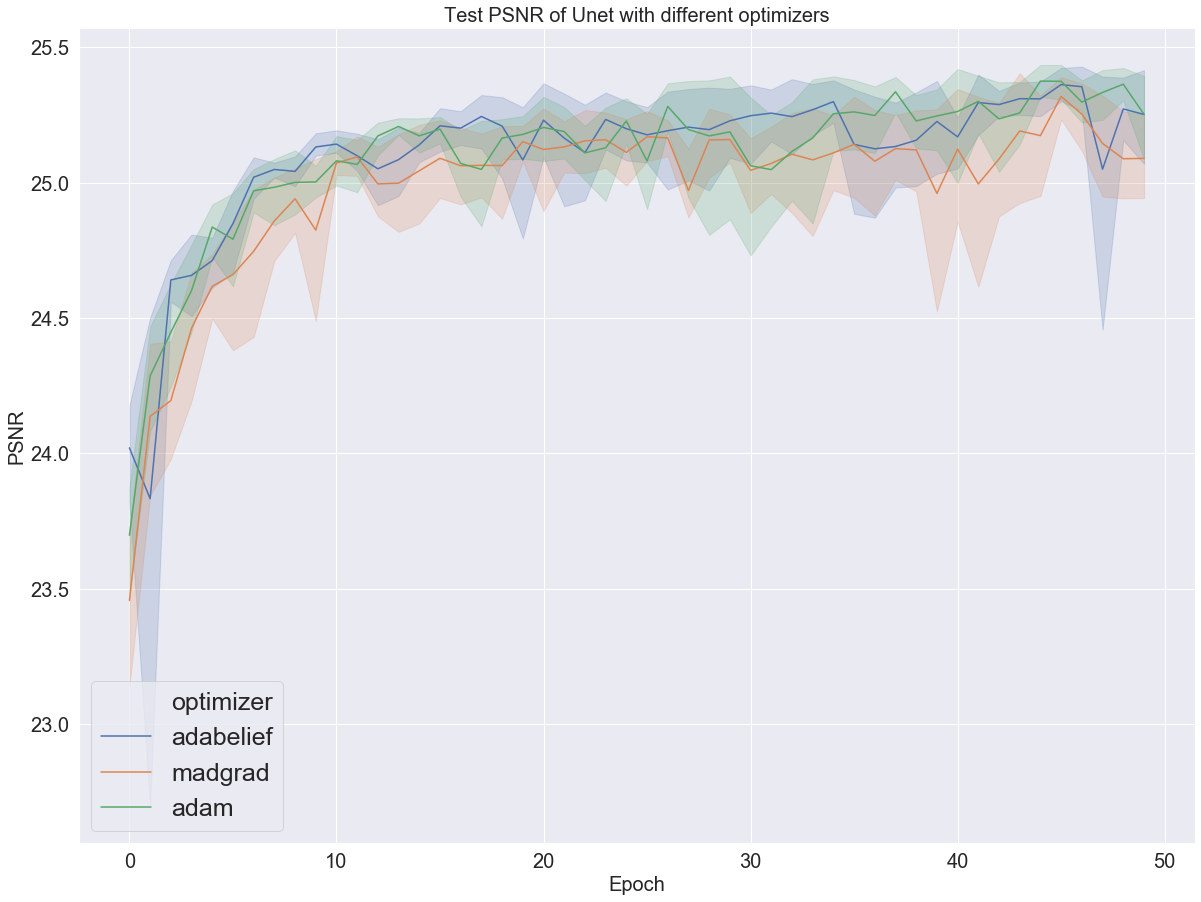

In [19]:
# Plot test psnr
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_results('psnr'), x='epoch', y='psnr', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Test PSNR of Unet with different optimizers', fontsize=20)
plt.ylabel('PSNR', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

Text(0.5, 0, 'Epoch')

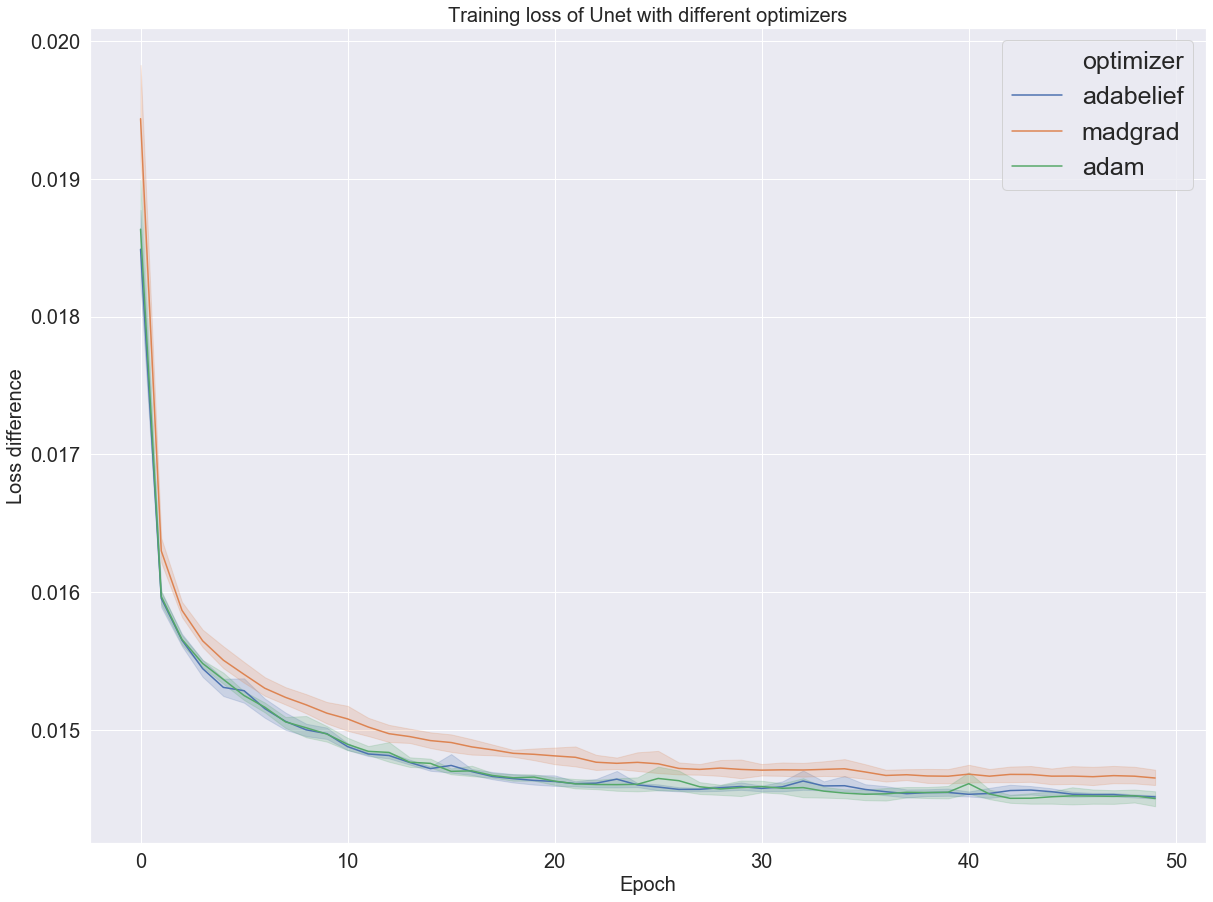

In [20]:
# Plot loss difference
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_results('loss'), x='epoch', y='loss', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Training loss of Unet with different optimizers', fontsize=20)
plt.ylabel('Loss difference', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

Plot tuned performance

In [21]:
def construct_dataframe_tuned_results(output = 'loss'):
    adabelief = np.zeros((5, 50))
    for i in range(5):
        adabelief[i, :] = np.load('adabelief_best_denoising/{}_Unet_best_adabelief_episode_{}.npy'.format(output, i))

    madgrad = np.zeros((5, 50))
    for i in range(5):
        madgrad[i, :] = np.load('madgrad_best_denoising/{}_Unet_best_madgrad_episode_{}.npy'.format(output, i))

    adam = np.zeros((5, 50))
    for i in range(5):
        adam[i, :] = np.load('adam_best_denoising/{}_Unet_best_adam_episode_{}.npy'.format(output, i))

    sgd = np.zeros((5, 50))
    for i in range(5):
        sgd[i, :] = np.load('sgd_best_denoising/{}_Unet_best_sgd_episode_{}.npy'.format(output, i))

    epochs = [i for i in range(50)]
    epochs = epochs + epochs + epochs+ epochs+ epochs
    observations = [i for i in range(5) for j in range(50)]
    adabelief_pd = pd.DataFrame(np.column_stack((adabelief.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adabelief_pd['optimizer'] = "adabelief"
    madgrad_pd = pd.DataFrame(np.column_stack((madgrad.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    madgrad_pd['optimizer'] = "madgrad"
    adam_pd = pd.DataFrame(np.column_stack((adam.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    adam_pd['optimizer'] = "adam"
    sgd_pd = pd.DataFrame(np.column_stack((sgd.flatten(),np.array(epochs), np.array(observations))),columns = [output, 'epoch', 'trial'])
    sgd_pd['optimizer'] = "sgd momentum"

    frames = [adabelief_pd, madgrad_pd, adam_pd, sgd_pd]
    return pd.concat(frames)

Text(0.5, 0, 'Epoch')

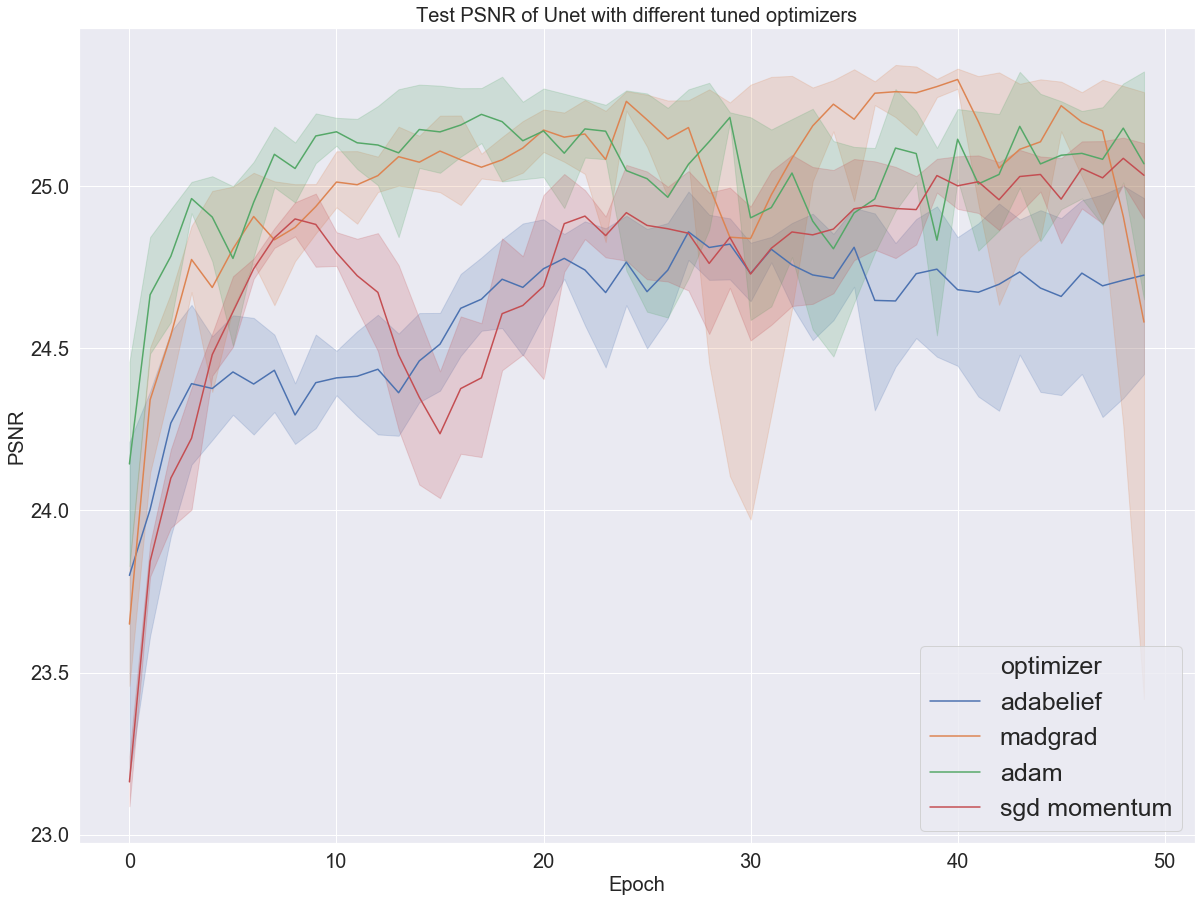

In [22]:
# Plot test psnr
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_tuned_results('psnr'), x='epoch', y='psnr', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Test PSNR of Unet with different tuned optimizers', fontsize=20)
plt.ylabel('PSNR', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

Text(0.5, 0, 'Epoch')

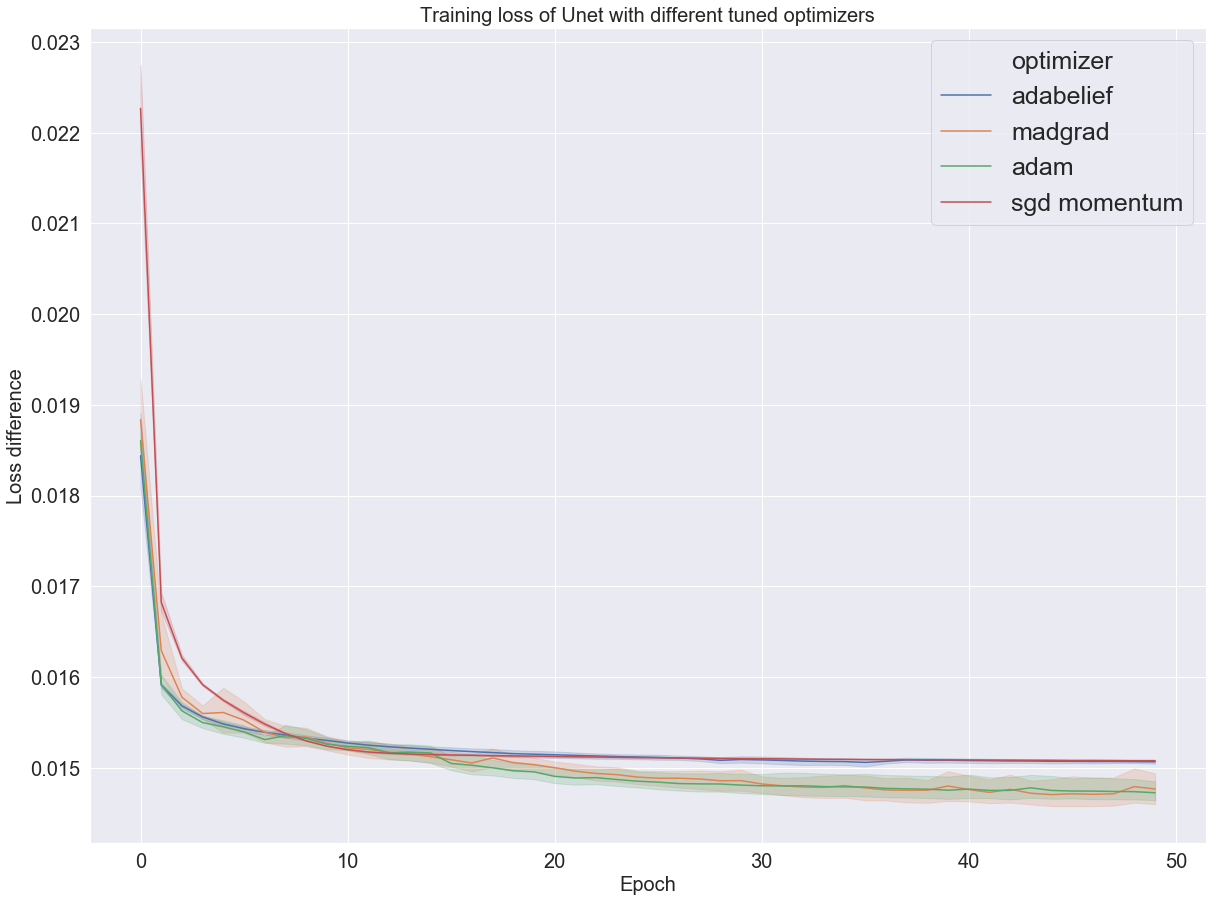

In [23]:
# Plot loss
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=construct_dataframe_tuned_results('loss'), x='epoch', y='loss', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Training loss of Unet with different tuned optimizers', fontsize=20)
plt.ylabel('Loss difference', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Epoch', fontsize=20)

Difference in performance between default and tuned hyperparameters

Text(0.5, 0, 'Epoch')

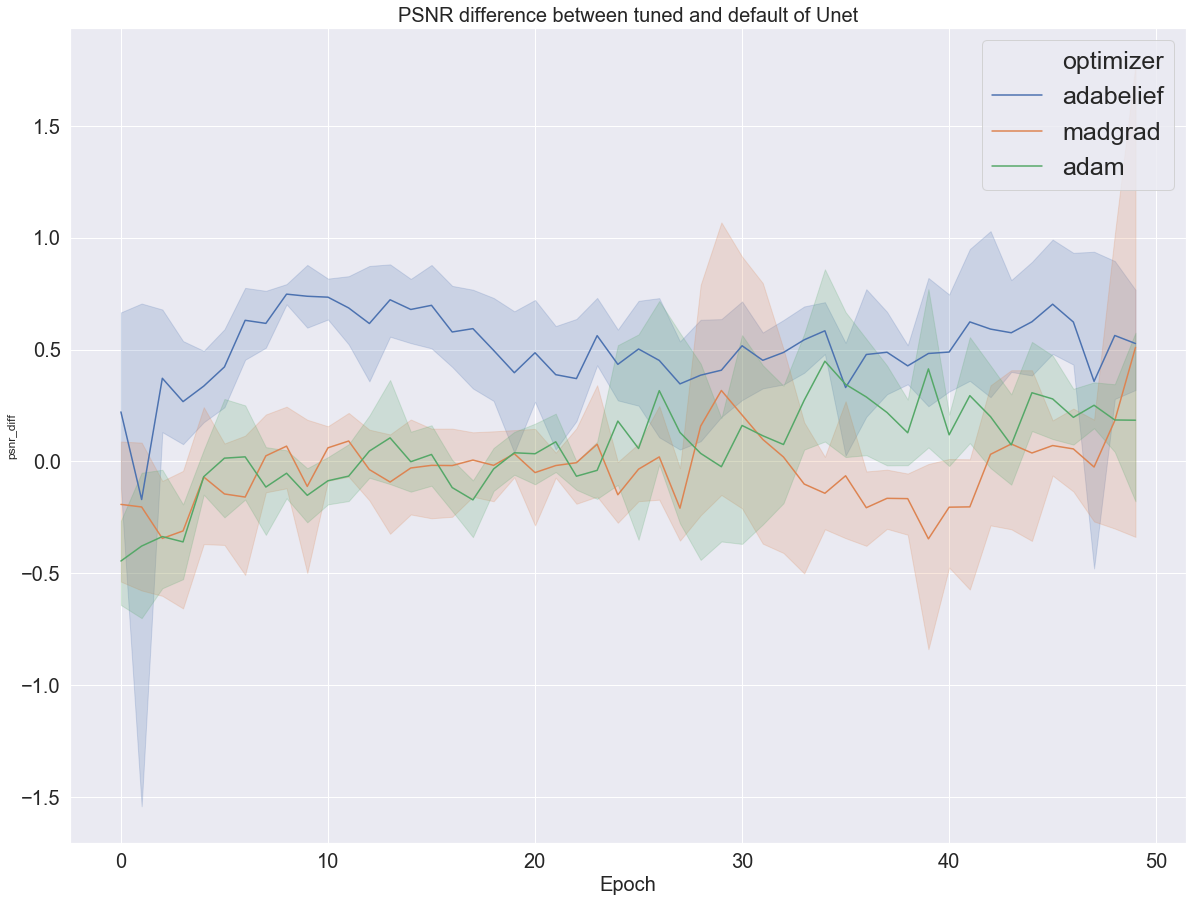

In [26]:
adabelief = np.zeros((5, 50))
for i in range(5):
    adabelief[i, :] = np.subtract(np.load('adabelief_denoising/psnr_Unet_adabelief_episode_{}.npy'.format(i)),
                                  np.load('adabelief_best_denoising/psnr_Unet_best_adabelief_episode_{}.npy'.format(i)))

madgrad = np.zeros((5, 50))
for i in range(5):
    madgrad[i, :] = np.subtract(np.load('madgrad_denoising/psnr_Unet_madgrad_episode_{}.npy'.format(i)),
                                  np.load('madgrad_best_denoising/psnr_Unet_best_madgrad_episode_{}.npy'.format(i)))

adam = np.zeros((5, 50))
for i in range(5):
    adam[i, :] = np.subtract(np.load('adam_denoising/psnr_Unet_adam_episode_{}.npy'.format(i)),
                                  np.load('adam_best_denoising/psnr_Unet_best_adam_episode_{}.npy'.format(i)))

# sgd = np.zeros((5, 50))
# for i in range(3):
#     sgd[i, :] = np.load('sgd_denoising/psnr_Unet_sgd_episode_{}.npy'.format(i))

import pandas as pd

epochs = [i for i in range(50)]
epochs = epochs + epochs + epochs + epochs + epochs
observations = [i for i in range(5) for j in range(50)]
adabelief_pd = pd.DataFrame(np.column_stack((adabelief.flatten(), np.array(epochs), np.array(observations))),
                            columns=['psnr_diff', 'epoch', 'trial'])
adabelief_pd['optimizer'] = "adabelief"
madgrad_pd = pd.DataFrame(np.column_stack((madgrad.flatten(), np.array(epochs), np.array(observations))),
                          columns=['psnr_diff', 'epoch', 'trial'])
madgrad_pd['optimizer'] = "madgrad"
adam_pd = pd.DataFrame(np.column_stack((adam.flatten(), np.array(epochs), np.array(observations))),
                       columns=['psnr_diff', 'epoch', 'trial'])
adam_pd['optimizer'] = "adam"
# sgd_pd = pd.DataFrame(np.column_stack((sgd.flatten(), np.array(epochs), np.array(observations))),
#                       columns=['psnr', 'epoch', 'trial'])
# sgd_pd['optimizer'] = "sgd momentum"
frames = [adabelief_pd, madgrad_pd, adam_pd]#, sgd_pd]
df = pd.concat(frames)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (20, 15)})
sns.lineplot(data=df, x='epoch', y='psnr_diff', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('PSNR difference between tuned and default of Unet', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('PSNR difference', fontsize=20)
plt.xlabel('Epoch', fontsize=20)

Text(0.5, 0, 'Epoch')

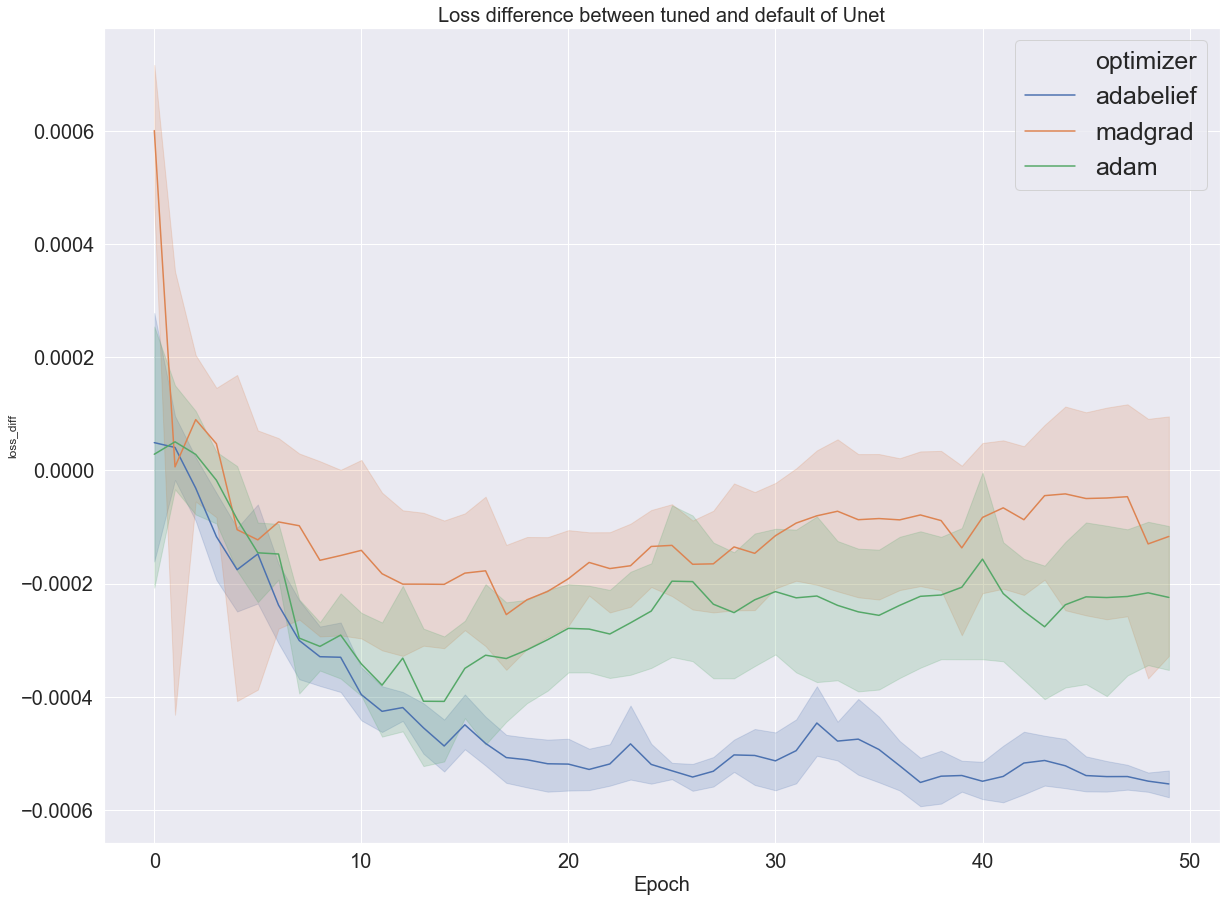

In [27]:
adabelief = np.zeros((5, 50))
for i in range(5):
    adabelief[i, :] = np.subtract(np.load('adabelief_denoising/loss_Unet_adabelief_episode_{}.npy'.format(i)),
                                  np.load('adabelief_best_denoising/loss_Unet_best_adabelief_episode_{}.npy'.format(i)))

madgrad = np.zeros((5, 50))
for i in range(5):
    madgrad[i, :] = np.subtract(np.load('madgrad_denoising/loss_Unet_madgrad_episode_{}.npy'.format(i)),
                                  np.load('madgrad_best_denoising/loss_Unet_best_madgrad_episode_{}.npy'.format(i)))

adam = np.zeros((5, 50))
for i in range(5):
    adam[i, :] = np.subtract(np.load('adam_denoising/loss_Unet_adam_episode_{}.npy'.format(i)),
                                  np.load('adam_best_denoising/loss_Unet_best_adam_episode_{}.npy'.format(i)))

# sgd = np.zeros((5, 50))
# for i in range(3):
#     sgd[i, :] = np.load('sgd_denoising/psnr_Unet_sgd_episode_{}.npy'.format(i))

import pandas as pd

epochs = [i for i in range(50)]
epochs = epochs + epochs + epochs + epochs + epochs
observations = [i for i in range(5) for j in range(50)]
adabelief_pd = pd.DataFrame(np.column_stack((adabelief.flatten(), np.array(epochs), np.array(observations))),
                            columns=['loss_diff', 'epoch', 'trial'])
adabelief_pd['optimizer'] = "adabelief"
madgrad_pd = pd.DataFrame(np.column_stack((madgrad.flatten(), np.array(epochs), np.array(observations))),
                          columns=['loss_diff', 'epoch', 'trial'])
madgrad_pd['optimizer'] = "madgrad"
adam_pd = pd.DataFrame(np.column_stack((adam.flatten(), np.array(epochs), np.array(observations))),
                       columns=['loss_diff', 'epoch', 'trial'])
adam_pd['optimizer'] = "adam"

frames = [adabelief_pd, madgrad_pd, adam_pd]#, sgd_pd]
df = pd.concat(frames)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (20, 15)})
sns.lineplot(data=df, x='epoch', y='loss_diff', hue='optimizer')
plt.legend(fontsize='25', title_fontsize='50')
plt.title('Loss difference between tuned and default of Unet', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Loss difference', fontsize=20)
plt.xlabel('Epoch', fontsize=20)